In [1]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data as data

In [2]:
from tqdm.notebook import tqdm,trange 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Loading

In [4]:
#Path for UTKFace images
imgPath='C:\\Users\\mrcoo\\Desktop\\UTKFace\\dataset/'

## Implementing a Custom Dataloader Class

In [5]:
class UTKFaceDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform):
        self.csv_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, 
                                self.csv_file.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label_age = self.csv_file.iloc[idx, 1]
        label_gender = self.csv_file.iloc[idx, 2]
        label_race = self.csv_file.iloc[idx, 3]
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label_age': label_age,
            'label_gender': label_gender,
            'label_race': label_race
        }

### Transforms

In [6]:
pretrained_size = 224

transforms_list = [
    transforms.Resize(pretrained_size),
    transforms.CenterCrop(pretrained_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.RandomCrop(pretrained_size, padding=10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(5)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3, 5])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3, 5])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3, 5])
    }
}

In [7]:
batch_size = 32

train_dataset = UTKFaceDataset(csv_file='C:\\Users\\mrcoo\\Desktop\\UTKFace\\train.csv',
                              root_dir = imgPath,
                              transform = transforms.Compose(transforms_dict['train'][2]))

valid_dataset = UTKFaceDataset(csv_file='C:\\Users\\mrcoo\\Desktop\\UTKFace\\valid.csv',
                              root_dir = imgPath,
                              transform = transforms.Compose(transforms_dict['val'][0]))

test_dataset = UTKFaceDataset(csv_file='C:\\Users\\mrcoo\\Desktop\\UTKFace\\test.csv',
                              root_dir = imgPath,
                              transform = transforms.Compose(transforms_dict['test'][0]))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of test examples: {len(test_dataset)}')

Number of training examples: 16392
Number of validation examples: 2893
Number of test examples: 4821


In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [10]:
def plot_images(images, labels, classes, normalize = True):
    
    n_images = len(images)
    
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize=(10,10))
    
    for i in range(rows*cols):
        
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [11]:
age_classes = ['0-2', '3-6', '7-13', '14-20', '21-32', '33-43', '44-53', '54-']

race_classes = ['White', 'Black', 'Asian', 'Indian', 'Others']

gender_classes = ['Male', 'Female']

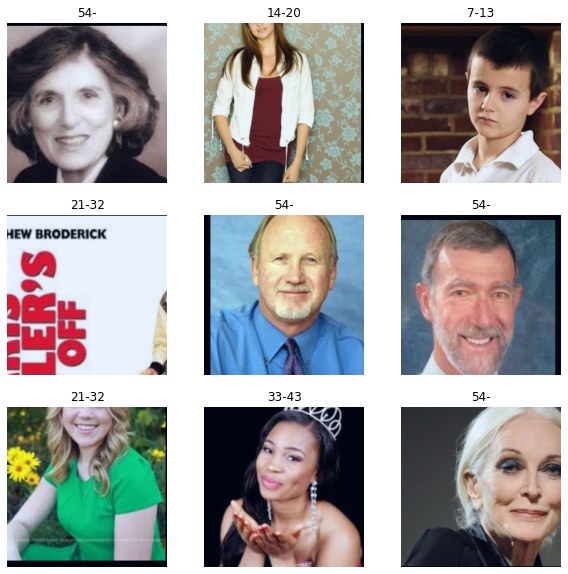

In [12]:
N_IMAGES = 9

images, labels = zip(*[(idx['image'], idx['label_age']) for idx in [train_dataset[i] for i in range(N_IMAGES)]])

plot_images(images, labels, age_classes)

In [13]:
# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         nn.init.normal_(m.weight, mean=0, std=1e-2)

In [14]:
import pretrainedmodels
class Net(nn.Module):
    def __init__(self, pretrained):
        super(Net, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["densenet161"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["densenet161"](pretrained=None)
        self.fc1 = nn.Linear(2208, 8)  #For age class
        self.fc2 = nn.Linear(2208, 2)    #For gender class
        self.fc3 = nn.Linear(2208, 5)    #For race class
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        label1 = self.fc1(x)
        label2= torch.sigmoid(self.fc2(x))  
        label3 = self.fc3(x)

        return {'label1': label1, 'label2': label2, 'label3': label3}

## Specify Loss Function and Optimizer

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [16]:
from torchsummary import summary

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") 
# # model = densenet161().to(device)
model = Net(True)
model = model.to('cpu')

#summary(model, torch.rand((1, 3, 224, 224)))

In [17]:
# model

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40000], gamma=0.1)

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
import torch
torch.cuda.empty_cache()

In [21]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

Training started


  0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/513 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch: 1 | Epoch Time: 207m 26s
Current learning rate is: 0.0001
Training Loss: 2.217781 	Validation Loss: 1.784826
Validation loss decreased (inf --> 1.784826)


Training:   0%|          | 0/513 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch: 2 | Epoch Time: 172m 27s
Current learning rate is: 0.0001
Training Loss: 1.715053 	Validation Loss: 1.709806
Validation loss decreased (1.784826 --> 1.709806)


Training:   0%|          | 0/513 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch: 3 | Epoch Time: 171m 13s
Current learning rate is: 0.0001
Training Loss: 1.526160 	Validation Loss: 1.717424


Training:   0%|          | 0/513 [00:01<?, ?it/s]

Evaluation:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch: 4 | Epoch Time: 161m 50s
Current learning rate is: 0.0001
Training Loss: 1.356357 	Validation Loss: 1.769211


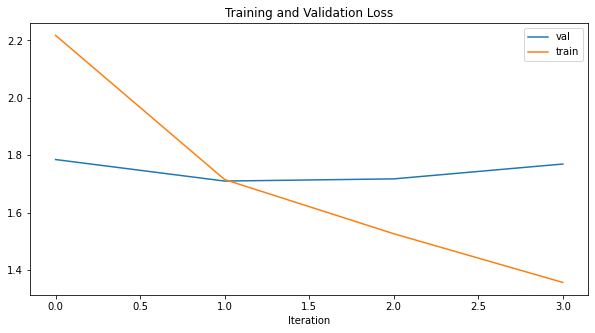

In [22]:
# number of epochs to train the model
n_epochs = 5


valid_loss_min = np.Inf # track change in validation loss
train_loss_list = []
valid_loss_list = []

print('Training started')
for epoch in trange(1, n_epochs):
    start_time = time.monotonic()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for batch in tqdm(train_loader, desc="Training", leave=False):
        # get data and move to GPU
        image, label1, label2, label3 = batch['image'].to('cpu'), batch['label_age'].to('cpu'), batch['label_gender'].to('cpu'), batch['label_race'].to('cpu')
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(image)
        label1_hat = output['label1']
        label2_hat = output['label2']
        label3_hat = output['label3']
        # calculate loss
        loss1 = criterion(label1_hat, label1.squeeze().long())
        loss2 = criterion(label2_hat, label2.squeeze().long())
        loss3 = criterion(label3_hat, label3.squeeze().long())        
        loss = loss1 + loss2 + loss3
        # backprop
        loss.backward()
        # grad
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()*image.size(0)
        
    ######################
    # validate the model #
    ######################
    model.eval()
    
    for batch in tqdm(valid_loader, desc="Evaluation", leave=False):
        # get data and move to GPU
        image, label1, label2, label3 = batch['image'].to('cpu'), batch['label_age'].to('cpu'), batch['label_gender'].to('cpu'), batch['label_race'].to('cpu')
        output = model(image)
        label1_hat = output['label1']
        label2_hat = output['label2']
        label3_hat = output['label3']
        # calculate loss
        loss1 = criterion(label1_hat, label1.squeeze().long())
        loss2 = criterion(label2_hat, label2.squeeze().long())
        loss3 = criterion(label3_hat, label3.squeeze().long())
        loss = loss1 + loss2 + loss3
        valid_loss += loss.item()*image.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    train_loss_list.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_loss_list.append(valid_loss)
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    # print training/validation statistics 
    for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))    
    print(f'Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f})')
        torch.save(model.state_dict(), 'model_prt_withRace.pt')
        valid_loss_min = valid_loss
        

plt.figure(figsize=(10,5))
plt.title('Training and Validation Loss')
plt.plot(valid_loss_list, label='val')
plt.plot(train_loss_list, label='train')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [23]:
model.load_state_dict(torch.load('model_prt_withRace.pt'))

<All keys matched successfully>

### Check Accuracy

In [24]:
def check_accuracy(model, dataloader, c):
#     labels_to_output = ''    
    if c == 'age':
        labels_to_output = 'label1'
    elif c == 'gender':
        labels_to_output = 'label2'
    elif c == 'race':
        labels_to_output = 'label3'
    
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        model.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch[f'label_{c}'].to(device)
            outputs = model(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs[labels_to_output]))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result

## Age

In [25]:
accuracy = check_accuracy(model, test_loader, 'age')

print(f"Age Accuracy: {accuracy['exact_match']*100/accuracy['total']}, \tOne-off Accuracy: {accuracy['one_off_match']*100/accuracy['total']}")

Age Accuracy: 67.47562746318191, 	One-off Accuracy: 93.83945239576852


### Gender

In [26]:
accuracy = check_accuracy(model, test_loader, 'gender')

print(f"Gender Accuracy: {accuracy['exact_match']*100/accuracy['total']}")

Gender Accuracy: 92.88529350757105


## Race

In [27]:
accuracy = check_accuracy(model, test_loader, 'race')

print(f"Race Accuracy: {accuracy['exact_match']*100/accuracy['total']}")

Race Accuracy: 82.05766438498237


## Confusion Matrix

In [28]:
ROOT_DIR = '.'
IMAGES_PATH = os.path.join(ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_matrix_func(data_loader, c, classes):
    # Initialize the prediction and label lists(tensors)
    predlist = torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0,dtype=torch.long, device='cpu')

    if c == 'age':
        labels_to_output = 'label1'
    elif c == 'gender':
        labels_to_output = 'label2'
    elif c == 'race':
        labels_to_output = 'label3'
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            with torch.no_grad():
                image, target = batch['image'].to(device), batch[f'label_{c}'].to(device)
                outputs = model(image)
                _, preds = torch.max(outputs[labels_to_output], 1)

                predlist = torch.cat([predlist, preds.view(-1).cpu()])
                lbllist = torch.cat([lbllist, target.view(-1).cpu()])

    # confusion matrix
    conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(f'For {c}: \n', conf_mat)
    
    print('#######################################\n\n\n')
    
    # Accuracy for each class label
    print(f'{c} accuracy for each class label')
    class_accuracy = 100 * conf_mat.diagonal()/conf_mat.sum(1)
    print(class_accuracy)
    
    
    print('#######################################\n\n\n')
    print('Conufsion Matrix HeatMap')
    target_names = classes

    cm = confusion_matrix(lbllist.numpy(), predlist.numpy(),)
    # Normalise=
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    sns.heatmap(cmn, annot=True, cmap='Blues', fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.title('')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    save_fig(f'{c} Confusion Matrix')
    plt.show(block=False)

## Age

For age: 
 [[ 317   68    0    0    1    0    0    0]
 [  19  134   23    0   11    1    0    1]
 [   4   26  105   26   25    0    0    6]
 [   0    3   44   75  133   11    1    5]
 [   0    2    7   13 1509  190   12   39]
 [   0    0    0    0  332  347   80   50]
 [   0    0    3    0   44  109  115  142]
 [   0    0    3    0   15   53   66  651]]
#######################################



age accuracy for each class label
[82.12435233 70.8994709  54.6875     27.57352941 85.15801354 42.89245983
 27.84503632 82.6142132 ]
#######################################



Conufsion Matrix HeatMap
Saving figure age Confusion Matrix


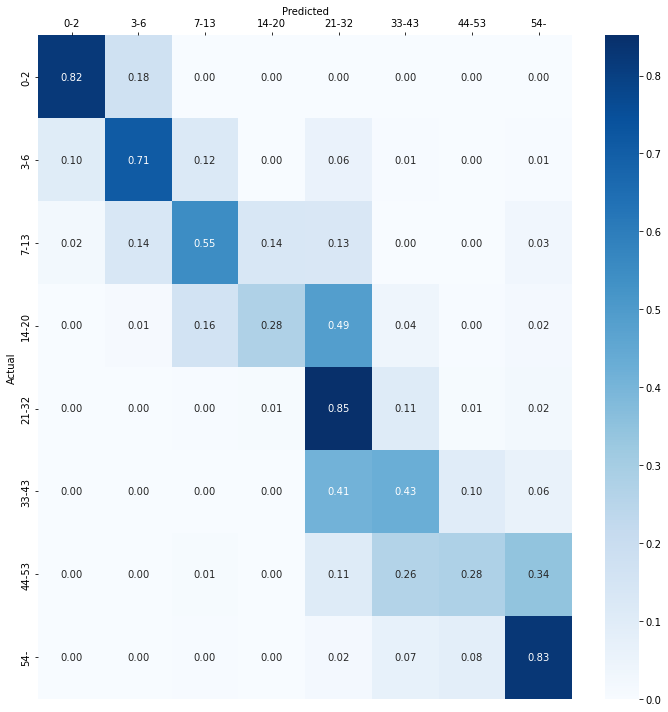

In [30]:
confusion_matrix_func(test_loader, 'age', age_classes)

## Gender

For gender: 
 [[2300  147]
 [ 196 2178]]
#######################################



gender accuracy for each class label
[93.99264405 91.74389217]
#######################################



Conufsion Matrix HeatMap
Saving figure gender Confusion Matrix


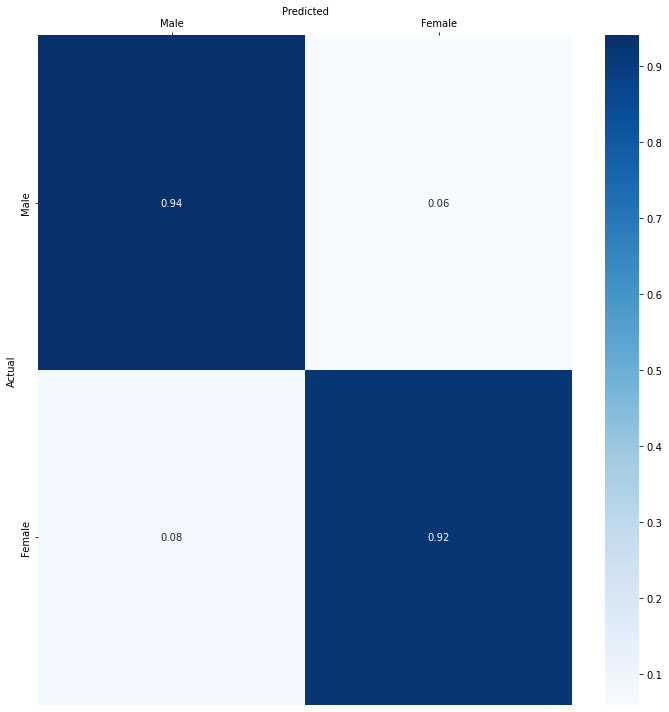

In [31]:
confusion_matrix_func(test_loader, 'gender', gender_classes)

## Race

For race: 
 [[1868   46   24   65   31]
 [  56  747    4   26   14]
 [  87   28  585   24   29]
 [  73   54    8  660   31]
 [ 146   35   11   73   96]]
#######################################



race accuracy for each class label
[91.8387414  88.19362456 77.68924303 79.9031477  26.59279778]
#######################################



Conufsion Matrix HeatMap
Saving figure race Confusion Matrix


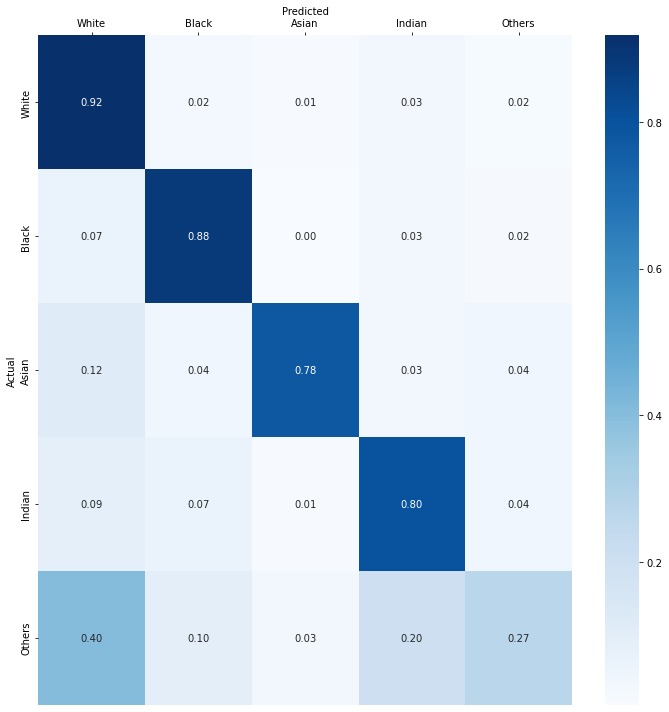

In [32]:
confusion_matrix_func(test_loader, 'race', race_classes)

# Confidence Level

#### We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [33]:
def get_predictions(model, iterator, c):

    if c == 'age':
        labels_to_output = 'label1'
    elif c == 'gender':
        labels_to_output = 'label2'
    elif c == 'race':
        labels_to_output = 'label3'
    
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for batch in iterator:
    
            x = batch['image'].to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred[labels_to_output], dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(batch[f'label_{c}'].cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [34]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

## Age Confidence Level

In [35]:
images, labels, probs = get_predictions(model, test_loader, 'age')

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

################

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

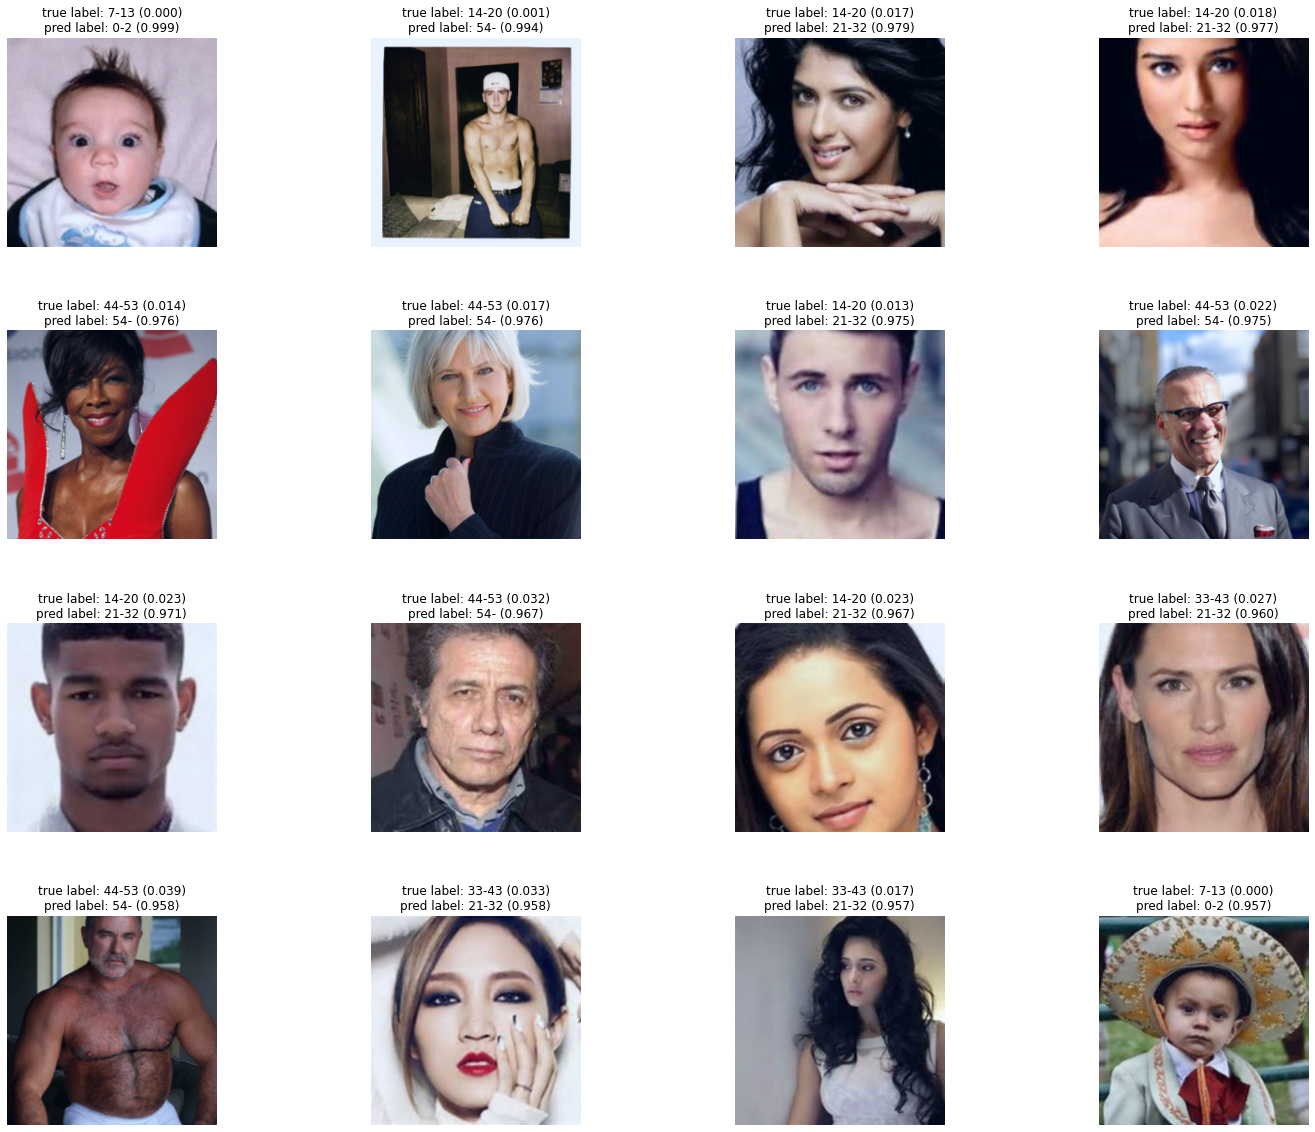

In [36]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, age_classes, N_IMAGES)

## Gender Confidence Level

In [37]:
images, labels, probs = get_predictions(model, test_loader, 'gender')

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

#####################################
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

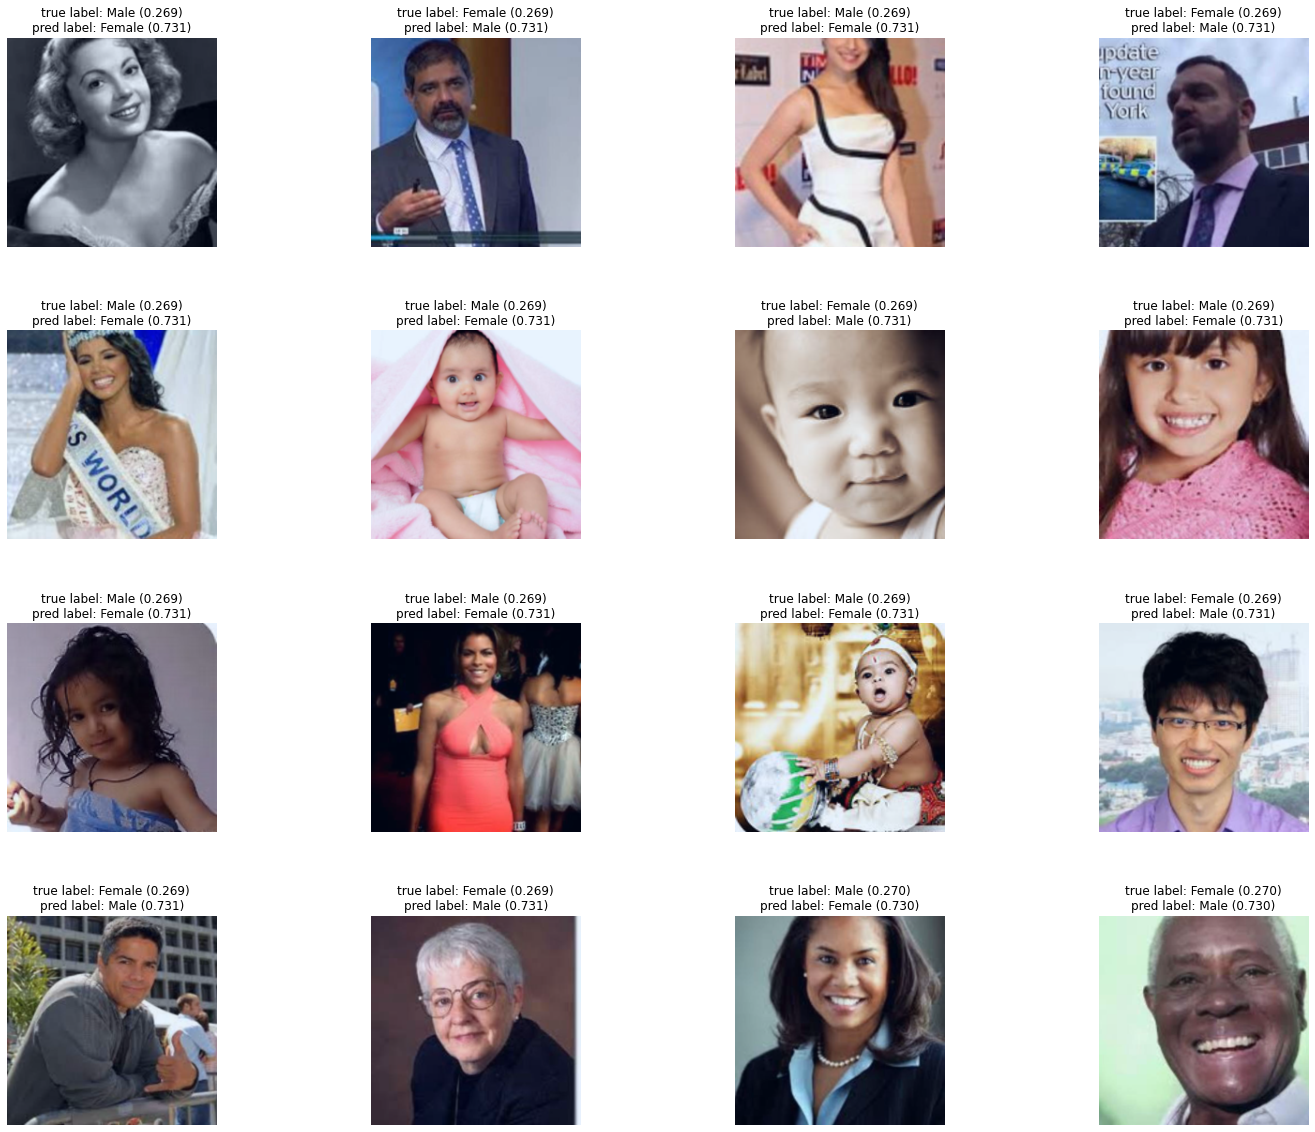

In [38]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, gender_classes, N_IMAGES)

## Race Confidence Level

In [39]:
images, labels, probs = get_predictions(model, test_loader, 'race')

pred_labels = torch.argmax(probs, 1)

corrects = torch.eq(labels, pred_labels)

#####################################
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

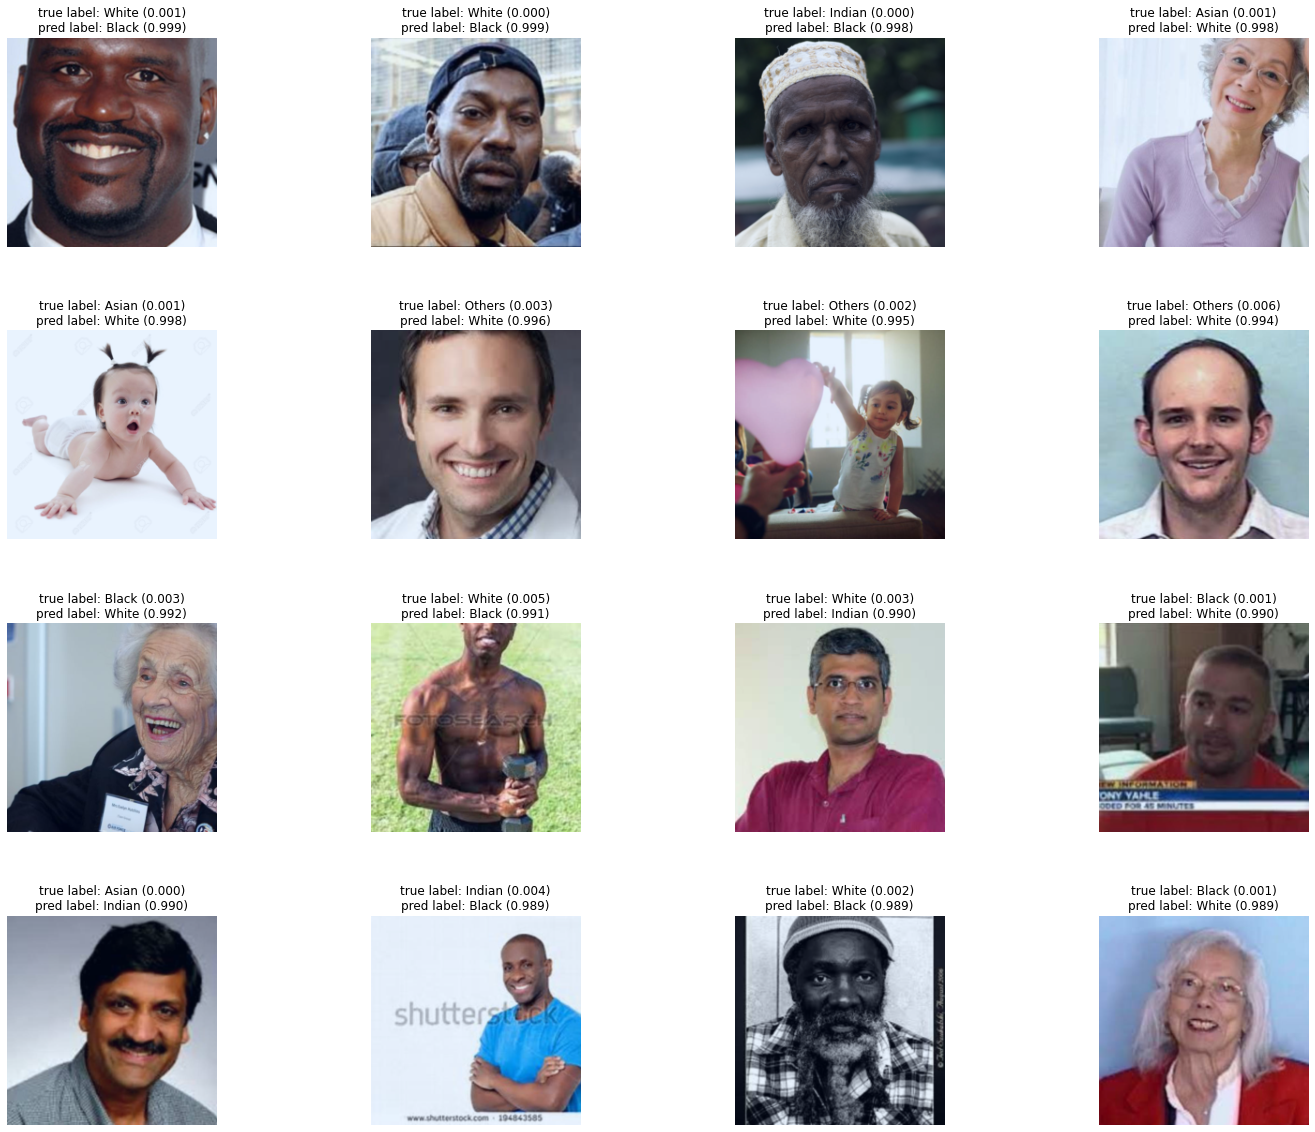

In [40]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, race_classes, N_IMAGES)